In [16]:
import numpy as np
import pandas as pd
import fabio
import matplotlib as mpl
import matplotlib.pyplot as plt
import kkcalc
from kkcalc import data
from kkcalc import kk
from matplotlib.colors import LogNorm
from matplotlib.patches import Circle
from adjustText import adjust_text

# Classes are imported here:
from GIWAXSDataProcessor import GIWAXSDataProcessor
from CrystalIndexingAnalyzer import CrystalIndexingAnalyzer

Load the X-ray scattering detector .tif image file, orient it, and make sure the beam center appears where it should

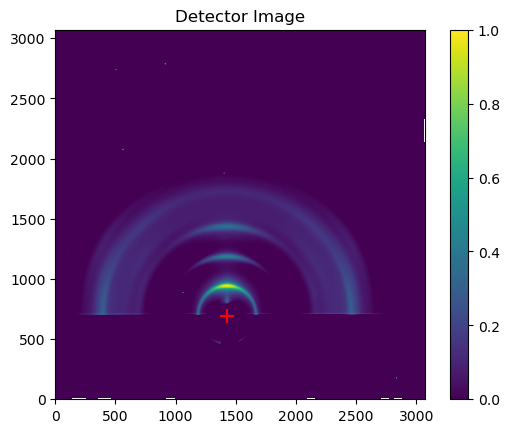

In [2]:
processor = GIWAXSDataProcessor()

file = r'.\example_data\EPEN_0p1deg_120s_08241133_0001.tif'

px_size_x, px_size_y = 0.073242, 0.073242 # mm, mm
bc_x, bc_y = 1427.66, 2381.05 # pixel coordinates
R = 289.52 # mm
xray_en= 12.7 # keV
q_range = 2 # inv A
q_res = 0.001 # inv A
incidence = 0.1 # degrees

image = np.flipud(fabio.open(file).data)
# Auto masking is optional - additional info is included in the source code
masked_image, mask = processor.automask(image, threshold_value=2)

plt.imshow(masked_image, origin = 'lower', norm=LogNorm(np.nanpercentile(image, 80)))
plt.scatter(bc_x, image.shape[1] - bc_y, color='red', s=100, marker='+', label='Beam Center')
plt.colorbar()
plt.title('Detector Image')
plt.show()

Map the detector image to q-space and apply intensity corrections

In [3]:
qzqxy = processor.img_to_qzqxy(masked_image, bc_x, bc_y, R, incidence, px_size_x, px_size_y, q_range, q_res, xray_en)

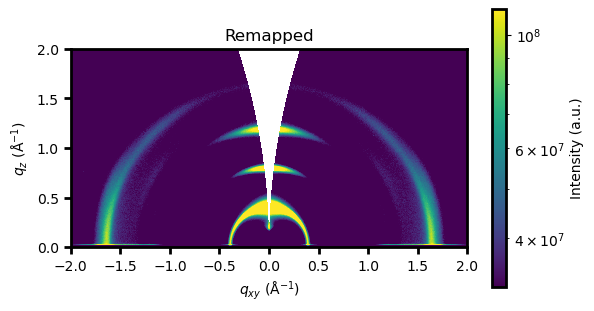

In [4]:
fig, ax = processor.plot_qzqxy(qzqxy, cmap='viridis')
plt.title('Remapped')
plt.show()

Cake by converting to polar coordinates and apply sin(chi) correction

In [5]:
chiq, corrected_chiq = processor.cake_and_corr(qzqxy)

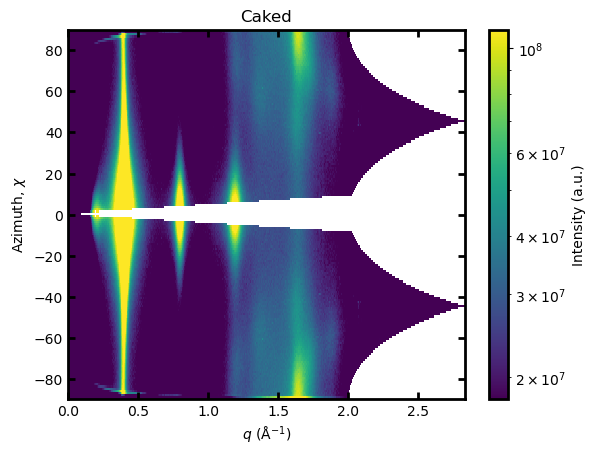

In [6]:
fig, ax = processor.plot_chiq(chiq, cmap='viridis')
plt.title('Caked')
plt.show()

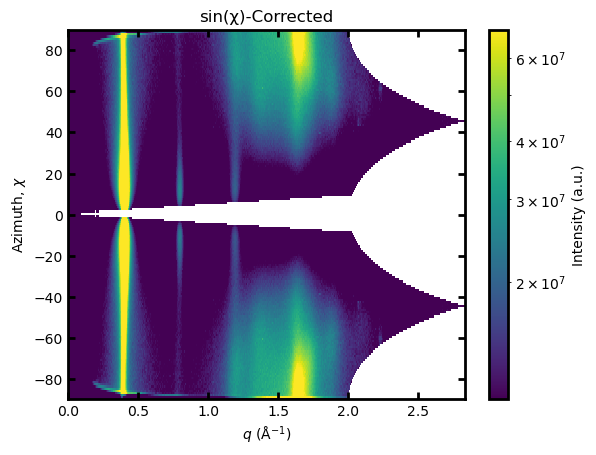

In [7]:
fig, ax = processor.plot_chiq(corrected_chiq, cmap='viridis')
plt.title('sin(χ)-Corrected')
plt.show()

Here, you can play with the space group, lattice dimensions, angles, and Miller indices to index. Assuming you don't know orientation, the plot simply draws lines at the q-values where the resultant peaks are expected

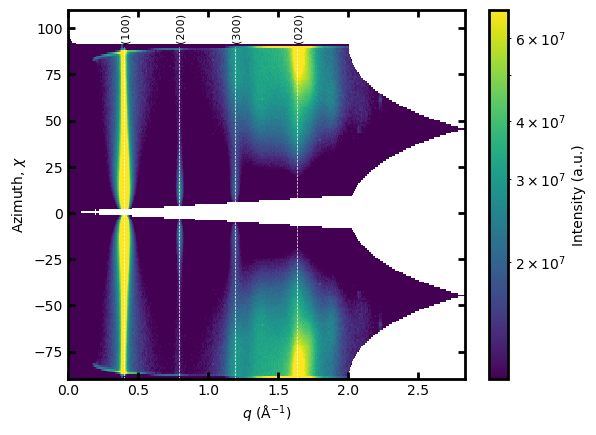

In [8]:
# Set display options for pandas DataFrame
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

# Initialize custom Miller indices and other parameters
custom_miller_indices = [(1, 0, 0), (2, 0, 0), (3, 0, 0), (0, 2, 0)]
# custom_miller_indices = []
max_miller_index = 3
space_group = 'monoclinic'
a = 15.8
b = 7.7
c = 7.6
alpha = 90
beta = 90
gamma = 87

# Create an object of CrystalIndexingAnalyzer
analyzer = CrystalIndexingAnalyzer(space_group, a, b, c, alpha, beta, gamma)

# Call the compute_spacing method
spacing_table = analyzer.compute_spacing(custom_miller_indices, max_miller_index)

# Sort the DataFrame by QSpace_AngstromInverse in ascending order
spacing_table = spacing_table.sort_values(by='QSpace_AngstromInverse')
                         
fig, ax = processor.plot_chiq(corrected_chiq, cmap='viridis')

ax.set_ylim([-90, 110])  # change upper y-axis limit

# Get the maximum q value from the chiq DataFrame
max_q = corrected_chiq['q'].max()

texts = []
# Iterate over DataFrame rows
for idx, row in spacing_table.iterrows():
    # Get q value and Miller indices
    q = row['QSpace_AngstromInverse']
    h, k, l = row['h'], row['k'], row['l']
    
    # If q is greater than max_q, break the loop
    if q > max_q:
        break
    
    # Check if all Miller indices are non-negative
    if all(index >= 0 for index in [h, k, l]):
        # Add vertical line at q
        ax.plot([q, q], [-90, 90], color='white', linestyle='--', linewidth=0.5)  # line span from -90 to +90

        # Create label with plus-minus sign before non-zero Miller indices
        miller_indices_label = f'({int(abs(h))}{int(abs(k))}{int(abs(l))})'  # Concatenate the indices without commas

        # Add label with Miller indices
        texts.append(ax.text(q, 102.5, miller_indices_label, rotation=90, fontsize=8, color='black'))  # change color to white

# Adjust the position of text labels
adjust_text(texts, expand_text=(1.05, 1.2), expand_points=(1.05, 1.2), force_text=(0.75, 0.75), force_points=(0.75, 0.75))

# Show the plot
plt.show()

If you can identify one of the Miller indices and specify it's orientation with a specific chi value, you can calculate where the other peaks will be relative to that one and attempt to index by comparison

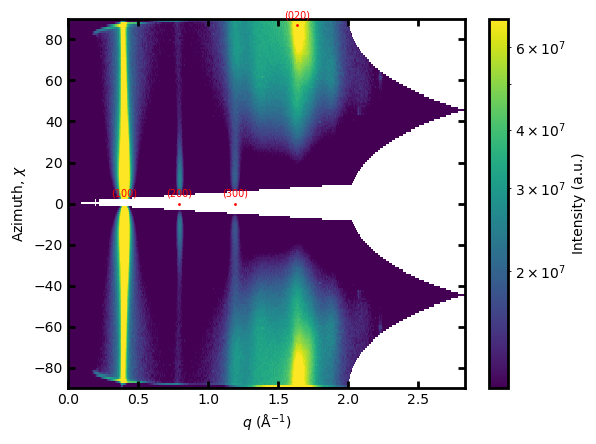

In [9]:
# User specified Miller indices (h1, k1, l1) and approximate chi value
h1, k1, l1 = 1, 0, 0 
approx_chi = 0

# Calculate 'Interplanar Angle' and 'Chi'
spacing_table = analyzer.calculate_interplanar_and_chi(spacing_table, h1, k1, l1, approx_chi = approx_chi)

# Generate the chi-q plot
fig, ax = processor.plot_chiq(corrected_chiq, cmap='viridis')

# Plot a circle at the chi and q of the user-specified Miller index
ref_q = spacing_table.loc[(spacing_table['h'] == h1) & (spacing_table['k'] == k1) & (spacing_table['l'] == l1), 'QSpace_AngstromInverse'].values[0]
ax.plot(ref_q, approx_chi, marker='.', markersize=2, color='white')

# Iterate through the rest of the list and plot the interplanar angles
for idx, row in spacing_table.iterrows():
    q = row['QSpace_AngstromInverse']
    chi = row['Chi']

    # If the current point is the reference point, skip it
    if row['h'] == h1 and row['k'] == k1 and row['l'] == l1:
        text = ax.annotate(f'({abs(int(h1))}{abs(int(k1))}{abs(int(l1))})', (ref_q, approx_chi), textcoords="offset points", xytext=(0,5), ha='center', color='red', fontsize=7)
        texts.append(text)
        continue

    # Plot a small dot for each other Miller index within the range of -90 to 90
    if -90 <= chi <= 90:
        ax.plot(q, chi, marker='.', markersize=2, color='red')
        text = ax.annotate(f'({abs(int(row["h"]))}{abs(int(row["k"]))}{abs(int(row["l"]))})', (q, chi), textcoords="offset points", xytext=(0,5), ha='center', color='red', fontsize=7)

# Show the plot
plt.show()

Below is the indexed P3HT

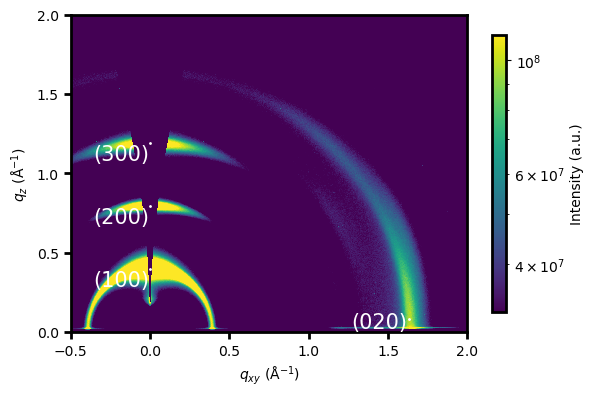

In [10]:
qxy_lower, qxy_upper = -0.5, 2 
qz_lower, qz_upper = 0, 2  

cmap = mpl.cm.viridis
cmap.set_bad((68/255, 1/255, 84/255), 1)

fig, ax = processor.plot_qzqxy(qzqxy, qxy_limits=(qxy_lower, qxy_upper), qz_limits=(qz_lower, qz_upper), cmap=cmap)

spacing_table = analyzer.compute_q_coordinates(spacing_table)

# Add your texts to a list instead of the plot
texts = []

# Plot a circle at the qxy and qz of the user-specified Miller index
ref_qxy = spacing_table.loc[(spacing_table['h'] == h1) & (spacing_table['k'] == k1) & (spacing_table['l'] == l1), 'qxy'].values[0]
ref_qz = spacing_table.loc[(spacing_table['h'] == h1) & (spacing_table['k'] == k1) & (spacing_table['l'] == l1), 'qz'].values[0]
ax.plot(ref_qxy, ref_qz, marker='.', markersize=2, color='white')
texts.append(ax.text(ref_qxy, ref_qz, f'({int(h1)}{int(k1)}{int(l1)})', ha='center', va='center', fontsize=15, color='white'))

for idx, row in spacing_table.iterrows():
    qxy = row['qxy']
    qz = row['qz']

    # Only plot points and labels if they're within the user-specified axis limits
    if qxy >= qxy_lower and qxy <= qxy_upper and qz >= qz_lower and qz <= qz_upper:
        # Skip the reference point
        if row['h'] == h1 and row['k'] == k1 and row['l'] == l1:
            continue
        ax.plot(qxy, qz, marker='.', markersize=2, color='white')
        texts.append(ax.text(qxy, qz, f'({abs(int(row["h"]))}{abs(int(row["k"]))}{abs(int(row["l"]))})', ha='center', va='center', fontsize=15, color='white'))

# Use adjust_text, which will take care of text overlapping
adjust_text(texts)

# Show the plot
plt.show()

You can also print the calculated values if they are of interest

In [11]:
spacing_table

,h,k,l,RealSpace_Angstroms,QSpace_AngstromInverse,Interplanar Angle,Chi,qxy,qz
0,1,0,0,15.800000,0.397670,0.0,0.0,0.00000,0.397670
1,2,0,0,7.900000,0.795340,0.0,0.0,0.00000,0.795340
2,3,0,0,5.266667,1.193010,0.0,0.0,0.00000,1.193010
3,0,2,0,3.850000,1.631996,87.0,87.0,1.62976,0.085412
4,0,-2,0,3.850000,1.631996,-93.0,-93.0,-1.62976,-0.085412


If you are familiar with xarray, access to the qzqxy, chiq, and corrected_chiq xarrays makes it convenient for various analysis, such as pole figure generation. For example, you can analyze the orientational distribution of the (020) peak, located between 1.6 and 1.68 inv A. 

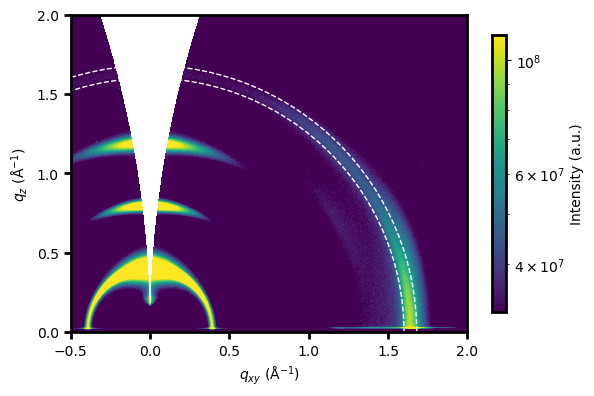

In [12]:
q_lower = 1.6
q_upper = 1.68

fig, ax = processor.plot_qzqxy(qzqxy, qxy_limits=(qxy_lower, qxy_upper), qz_limits=(qz_lower, qz_upper), cmap='viridis')

# Add dashed circles
circle_lower = Circle((0, 0), q_lower, color='white', fill=False, linestyle='dashed', linewidth=1)
circle_upper = Circle((0, 0), q_upper, color='white', fill=False, linestyle='dashed', linewidth=1)

ax.add_artist(circle_lower)
ax.add_artist(circle_upper)

# Show the plot
plt.show()

It is important to note that information near 0 degrees (within the missing wedge) is inaccessible, so the resultant distribution assumes no population centered near 0 degrees.

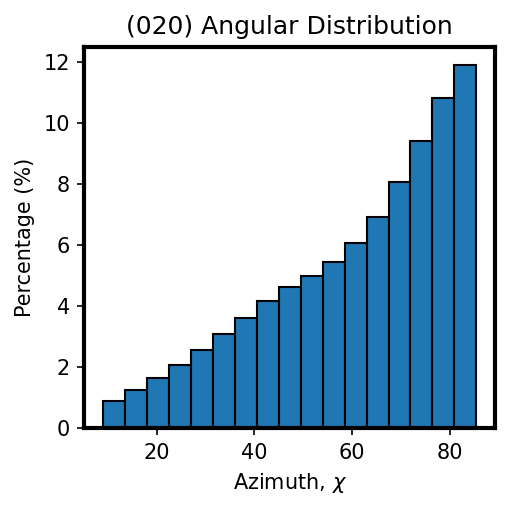

In [13]:
negative_chi = corrected_chiq.sel(q=slice(q_lower,q_upper), chi=slice(-90,0)).mean('q')
negative_chi['chi'] = abs(negative_chi['chi'])
positive_chi = corrected_chiq.sel(q=slice(q_lower,q_upper), chi=slice(0,90)).mean('q')

chi_common = np.linspace(0, 90, num=100)
negative_chi = negative_chi.interp(chi=chi_common)
positive_chi = negative_chi.interp(chi=chi_common)

# averaging the two datasets
average_chi = 0.5 * (negative_chi + positive_chi)

# Normalize the data so it sums to 1
normalized_chi = average_chi / average_chi.sum()

# Convert to percentage
percentage_chi = normalized_chi * 100

# Create a histogram plot
fig, ax = plt.subplots(figsize=(3.5, 3.5), dpi=150)
ax.hist(percentage_chi['chi'], weights=percentage_chi, bins=20, edgecolor='black')
ax.set_xlabel('Azimuth, $\\it{χ}$')
ax.set_ylabel('Percentage (%)')
plt.title('(020) Angular Distribution')
plt.tight_layout()
plt.show()

As an exercise, consider analyzing the LaB6 calibration file included in the example data to verify that the isotropic LaB6 has a random distribution. 

Next, let's consider depth profiling, where the incidence angle is proportional to the penetration depth of X-rays according to:

$$
\Lambda = \frac{\lambda}{4\pi} \sqrt{\frac{2}{\sqrt{(\alpha_i^2 - \alpha_c^2)^2 + 4\beta^2} - (\alpha_i^2 - \alpha_c^2)}}
$$


where:

- $\Lambda$ is the penetration depth.
- $\lambda$ is the wavelength.
- $\alpha_i$ is the grazing incidence angle (less than 1 degree).
- $\alpha_c$ is the critical angle.
- $\beta$ is the imaginary part of the material's refractive indices at the given X-ray energy.


$$
\alpha_c = \sqrt{2\delta}
$$


where:

- $\alpha_c$ is the critical angle.
- $\delta$ is the real part of the material's refractive indices at the given X-ray energy..


We can estimate $\delta$ and $\beta$ using kkcalc (based on the Henke database for atomic scattering factors) knowing the density and stoichiometry.

In [54]:
stoichiometry = kk.data.ParseChemicalFormula('C10H14S')
formula_mass = kk.data.calculate_FormulaMass(stoichiometry)
density = 1.1 # g/cm3

# Calculate Atomic Scattering Factors from Henke Database
ASF_E, ASF_Data = kk.data.calculate_asf(stoichiometry)
ASF_Data2 = kk.data.coeffs_to_ASF(ASF_E, np.vstack((ASF_Data, ASF_Data[-1])))

beta_cont = kk.data.convert_data(np.column_stack((ASF_E, ASF_Data2)),'ASF','refractive_index', Density=density, Formula_Mass=formula_mass)

In [55]:
beta = np.interp(12700, beta_cont[:, 0], beta_cont[:, 1])
print(beta)

4.525857859338693e-09


In [60]:
# Make sure these energies encompass the energy of your X-ray beam
merge_min = 10000
merge_max = 15000
merged = kk.data.merge_spectra(np.column_stack((ASF_E, ASF_Data2)), ASF_E, ASF_Data, merge_points=(merge_min,merge_max), add_background=False, fix_distortions=False, plotting_extras=True)

# Calculate relativistic correction
correction = kk.calc_relativistic_correction(stoichiometry)

# Calculate real component of ASF from merged data
real = kk.KK_PP(merged[2][:,0], merged[0], merged[1], correction)

In [61]:
delta = np.interp(12700, delta_cont[:, 0], delta_cont[:, 1])
print(delta)

1.5375107724201629e-06


The beam center for the angle-resolved series of images is at bc_x = 1535.46, bc_y = 2908, and sample-to-detector distance (R) = 315.395 mm